In [1]:
import xml.etree.cElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.gridspec import GridSpec

In [2]:
%matplotlib inline

Count the number of records and the tags associated with the record

In [199]:
eventcount=0
artcount=0
artopen=0
articlesTag=[]
for event,elem in ET.iterparse('DataScience/pubmedJanToM.xml',events=('start','start-ns','end','end-ns')):
    eventcount=eventcount+1
    if (event=='start' or event=='start-ns') and eventcount==1:
        roottag=elem.tag
    elif (event=='start' or event=='start-ns') and artopen==0:
        arttag=elem.tag
        artopen=1
        articlesTag.append(arttag)
    elif (event=='end' or event=='end-ns') and elem.tag==arttag:
        artcount=artcount+1
        artopen=0
        arttag=''
    elem.clear()

print(eventcount,roottag,arttag)
print(len(articlesTag))
set(articlesTag)

111424668 PubmedArticleSet 
373502


{'PubmedArticle', 'PubmedBookArticle'}

Look at one record and since we are only interested in research articles and not books, we will look at that

In [80]:
artcount=0
idfound=0
for event,elem in ET.iterparse('DataScience/pubmedJanToM.xml'):
    if elem.tag=='GrantID':
        idfound=1
    
    if elem.tag=='PubmedArticle' and idfound==1:
        break
        
    if elem.tag=='PubmedArticle' and idfound==0:
        elem.clear()
    

print(ET.tostring(elem, encoding='utf8').decode('utf8'))

<?xml version='1.0' encoding='utf8'?>
<PubmedArticle>
    <MedlineCitation Owner="NLM" Status="In-Process">
        <PMID Version="1">29534793</PMID>
        <DateRevised>
            <Year>2018</Year>
            <Month>04</Month>
            <Day>01</Day>
        </DateRevised>
        <Article PubModel="Print-Electronic">
            <Journal>
                <ISSN IssnType="Electronic">1873-4324</ISSN>
                <JournalIssue CitedMedium="Internet">
                    <Volume>1017</Volume>
                    <PubDate>
                        <Year>2018</Year>
                        <Month>Aug</Month>
                        <Day>09</Day>
                    </PubDate>
                </JournalIssue>
                <Title>Analytica chimica acta</Title>
                <ISOAbbreviation>Anal. Chim. Acta</ISOAbbreviation>
            </Journal>
            <ArticleTitle>A competitive lateral flow assay for the detection of tenofovir.</ArticleTitle>
            <Pagination>
  

Reading the file and extracting Authors, grant ID and keywords associated with each record. The cell below took 4 mins to run.

In [3]:
artind=1

authno=1
authorlist=[]
firstname=None
lastname=None
affiliation=None

grantno=1
grantidlist=[]

keywordno=1
keywordslist=[]

for event,elem in ET.iterparse('pubmedJanToM.xml'):
    if elem.tag=='PubmedArticle':
        artind=artind+1
        authno=1
        grantno=1
        keywordno=1
        elem.clear()
        
    if elem.tag=='Author':
        if elem.find('ForeName') is not None:
            firstname=elem.find('ForeName').text
        if elem.find('LastName') is not None:
            lastname=elem.find('LastName').text
        if elem.find('AffiliationInfo') is not None:
            affiliation=elem.find('AffiliationInfo').find('Affiliation').text
        authorlist.append({'artind': artind, 'authno': authno, 'FirstName': firstname, 'LastName': lastname, 'affiliation': affiliation})
        authno=authno+1
        firstname=None
        lastname=None
        affiliation=None
        
    if elem.tag=='GrantID':
        grantidlist.append({'artind': artind, 'grantno': grantno, 'grantid': elem.text})
        grantno=grantno+1
    
    if elem.tag=='Keyword':
        keywordslist.append({'artind': artind, 'keywordno': keywordno, 'keyword': elem.text})
        keywordno=keywordno+1
    

In [4]:
keywordslistDF=pd.DataFrame(keywordslist).set_index('artind')
authorlistDF=pd.DataFrame(authorlist).set_index('artind')
grantidlistDF=pd.DataFrame(grantidlist).set_index('artind')

Counting the number of records that have authors associated with them and keywords associated with them

In [5]:
TotRecordskeyW=len(set(keywordslistDF.index))
TotRecordsAuth=len(set(authorlistDF.index))
len(set(authorlistDF.index)),len(set(keywordslistDF.index)),len(set(grantidlistDF.index))

(368274, 249352, 39011)

In [20]:
keywordslistDF.head()

,keyword,keywordno
artind,,
1,Reactive oxygen species,1
1,antioxidant enzymes,2
1,apoptosis,3
1,chemical agents,4
1,diet,5


In [21]:
authorlistDF.head()

,FirstName,LastName,affiliation,authno
artind,,,,
1,Kaitlyn,Beyfuss,"a School of Kinesiology and Health Sciences , ...",1
1,David A,Hood,"a School of Kinesiology and Health Sciences , ...",2
2,Shan-Shan,Hong,"a Obstetrics and Gynecology Hospital , Fudan U...",1
2,Ming-Xing,Zhang,"a Obstetrics and Gynecology Hospital , Fudan U...",2
2,Meng,Zhang,"a Obstetrics and Gynecology Hospital , Fudan U...",3


In [22]:
grantidlistDF.head()

,grantid,grantno
artind,,
168,U54 EB015403,1
168,UL1 TR001430,2
183,K23 HL128885,1
183,L40 HL124407,2
183,U01 HL133883,3


Reading in the names of top universities

In [6]:
UnivNames=pd.read_csv('timesData.csv')

Getting top 10 universities from different countries

In [7]:
UnivNamesUS=UnivNames.loc[UnivNames['country']=='United States of America','university_name']
UnivNamesChina=UnivNames.loc[UnivNames['country']=='China','university_name']
UnivNamesIndia=UnivNames.loc[UnivNames['country']=='India','university_name']
UnivNamesJapan=UnivNames.loc[UnivNames['country']=='Japan','university_name']
UnivNamesKorea=UnivNames.loc[UnivNames['country']=='Korea','university_name']
print(UnivNamesUS.count(),UnivNamesChina.count(),UnivNamesIndia.count(),UnivNamesJapan.count(),UnivNamesKorea.count())
UnivNamesUS.iloc[0:10]

659 83 30 98 0


0                        Harvard University
1        California Institute of Technology
2     Massachusetts Institute of Technology
3                       Stanford University
4                      Princeton University
7        University of California, Berkeley
9                           Yale University
10    University of California, Los Angeles
11                    University of Chicago
12                 Johns Hopkins University
Name: university_name, dtype: object

Number of publications for top 10 universities from different countries

In [8]:
TotPubsPerUnivUS=[len(set(authorlistDF[authorlistDF.affiliation.str.contains(univ)==True].index)) for univ in UnivNamesUS.iloc[0:10]]
TotPubsPerUnivChina=[len(set(authorlistDF[authorlistDF.affiliation.str.contains(univ)==True].index)) for univ in UnivNamesChina.iloc[0:10]]
TotPubsPerUnivIndia=[len(set(authorlistDF[authorlistDF.affiliation.str.contains(univ)==True].index)) for univ in UnivNamesIndia.iloc[0:10]]
TotPubsPerUnivJapan=[len(set(authorlistDF[authorlistDF.affiliation.str.contains(univ)==True].index)) for univ in UnivNamesJapan.iloc[0:10]]

In [9]:
PerOFPubsPerCountry=[sum(np.array(TotPubsPerUnivUS)*100/TotRecordsAuth),sum(np.array(TotPubsPerUnivChina)*100/TotRecordsAuth),sum(np.array(TotPubsPerUnivIndia)*100/TotRecordsAuth),sum(np.array(TotPubsPerUnivJapan)*100/TotRecordsAuth)]
PerOFPubsPerCountry

[2.9825618968485426, 3.51640354735876, 0.25877471665118906, 2.640425335483906]

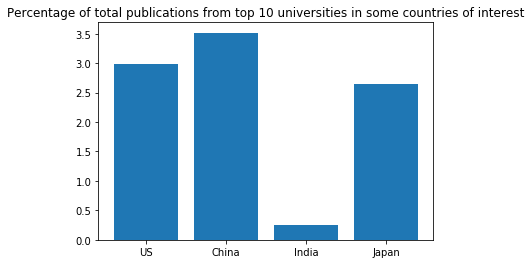

In [11]:
plt.figure(facecolor='w')
x = np.arange(4)
#counts=[UnivNamesUS.count(),UnivNamesChina.count(),UnivNamesIndia.count(),UnivNamesJapan.count(),UnivNamesKorea.count()]
plt.bar(x,PerOFPubsPerCountry)
plt.xticks(x,('US','China','India','Japan'))
plt.title('Percentage of total publications from top 10 universities in some countries of interest')
plt.savefig('PubsPerCountry.png',bbox_inches='tight')

Number of publications for top 10 universities in US

[773, 222, 654, 2386, 297, 649, 1430, 947, 1199, 2427]


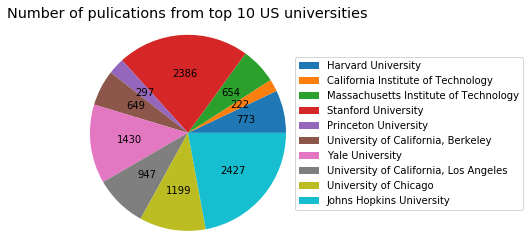

In [12]:
print(TotPubsPerUnivUS)
def absolute_value(val):
    a  = int(round(val*sum(TotPubsPerUnivUS)/100))
    return a

plt.figure(facecolor='white')
pie = plt.pie(TotPubsPerUnivUS,autopct=absolute_value)
plt.axis('equal')
plt.title('Number of pulications from top 10 US universities',ma='center',backgroundcolor='white',size='x-large')
plt.legend(pie[0],UnivNamesUS.iloc[0:10], bbox_to_anchor=(1.3,0.5), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)

Number of publications for specific research fields

In [14]:
keywordOfInt=['cancer','alzheimer','hiv','diabetes','autism','machine learning','neural networks','deep learning']

In [15]:
TotPubsPerKWOfInt=[len(set(keywordslistDF[keywordslistDF.keyword.str.lower().str.contains(keyw)==True].index)) for keyw in keywordOfInt]
TotPubsPerKWOfInt

[15491, 1774, 2002, 4121, 818, 471, 183, 163]

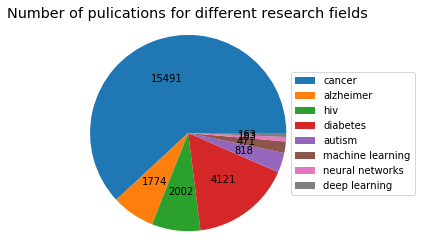

In [154]:
def absolute_value(val):
    a  = int(round(val*sum(TotPubsPerKWOfInt)/100))
    return a

plt.figure(facecolor='white')
plt.pie(TotPubsPerKWOfInt,autopct=absolute_value)
plt.axis('equal')
plt.title('Number of pulications for different research fields',ma='center',backgroundcolor='white',size='x-large')
plt.legend(pie[0],keywordOfInt, bbox_to_anchor=(1.05,0.5), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)

Number of publications for specific research fields as a function of university

In [34]:
PubindSetPerUniv=[set(authorlistDF[authorlistDF.affiliation.str.contains(univ)==True].index) for univ in UnivNamesUS.iloc[0:10]]

In [16]:
PubindSetPerKWOfInt=[set(keywordslistDF[keywordslistDF.keyword.str.lower().str.contains(keyw)==True].index) for keyw in keywordOfInt]

In [40]:
TotPubsPerKWOfIntPerUniv=[len(PubindSetPerKWOfInt[i] & PubindSetPerUniv[j]) for i in range(len(keywordOfInt)) for j in range(10)]

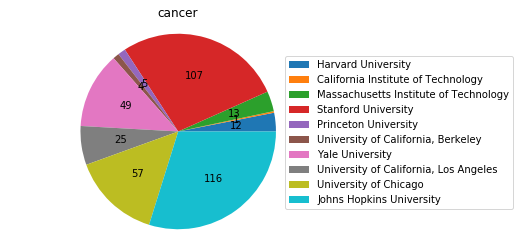

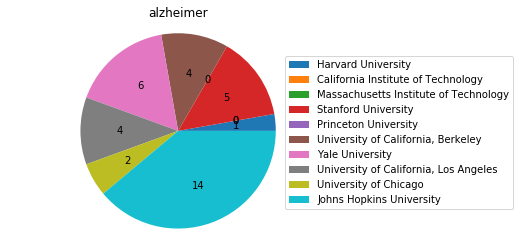

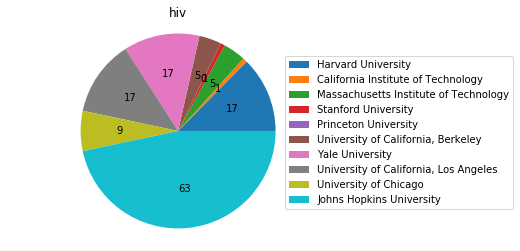

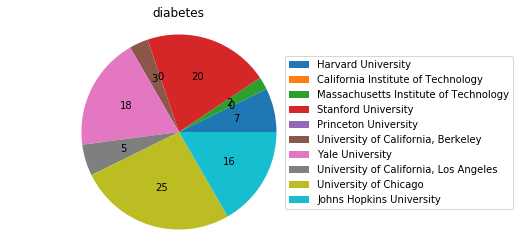

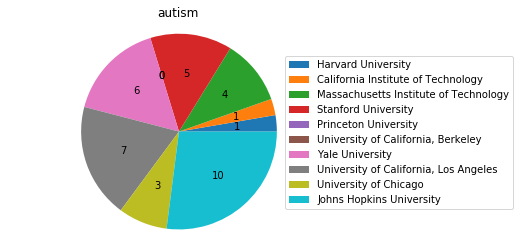

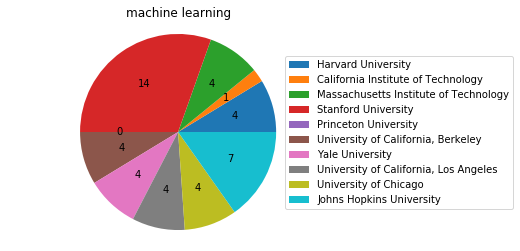

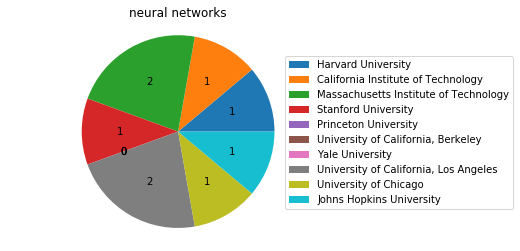

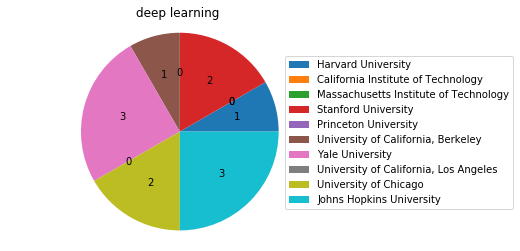

In [197]:
def absolute_value(val):
    a  = int(round(val*sum(TotPubsPerKWOfIntPerUniv[i:j])/100))
    return a

for c in range(len(keywordOfInt)):
    plt.figure(facecolor='white')
    i=c*10
    j=i+10
    plt.pie(TotPubsPerKWOfIntPerUniv[i:j],autopct=absolute_value)#'%1.1f%%')
    plt.axis('equal')
    plt.title(keywordOfInt[c])
    plt.legend(pie[0],UnivNamesUS.iloc[0:10], bbox_to_anchor=(1.3,0.5), loc="right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)
    plt.savefig(keywordOfInt[c]+'Pubs.png',bbox_inches='tight')

Top 5 grants in terms of publications identified based only on Grant ID. To be updated to include other grant attributes to uniqely identify grants

In [66]:
TotPubsPerGrant=grantidlistDF.reset_index().groupby('grantid').agg({'artind': lambda x: len(set(x))}).rename(columns={'artind': 'TotNoOfPubs'}).sort_values(by='TotNoOfPubs',ascending=False).loc[:,'TotNoOfPubs']

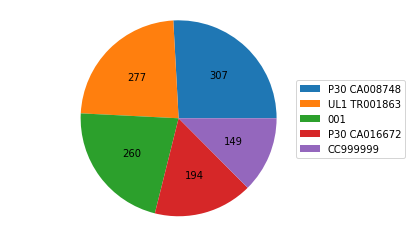

In [79]:
def absolute_value(val):
    a  = int(round(val*sum(TotPubsPerGrant.values[0:5])/100))
    return a

#plt.pie(TotPubsPerUniv,labels=UnivNamesUS.iloc[0:10],autopct=absolute_value)
pie = plt.pie(TotPubsPerGrant.values[0:5],autopct=absolute_value)
plt.axis('equal')
plt.legend(pie[0],list(TotPubsPerGrant.index)[0:5], bbox_to_anchor=(1.05,0.5), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)
plt.show()